In [1]:
import io
import pandas as pd
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
import numpy as np

In [2]:
import pandas as pd
import numpy as np
import random
import re, string
from konlpy.tag import Komoran, Hannanum
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from keybert import KeyBERT

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [24]:
df1 = pd.read_csv('data/머니투데이_샘플데이터(50,374개).csv')
df2 = pd.read_csv('data/매일경제_샘플데이터(41,319개).csv')
df3 = pd.read_csv('data/조선일보_샘플데이터(15,834개).csv')
df4 = pd.read_csv('data/중앙일보_샘플데이터(27,732개).csv')
df5 = pd.read_csv('data/한국경제_샘플데이터(48,884개).csv')

### 뉴스 전처리

In [25]:
news_df = pd.concat([df1[:10000], df2[:10000], df3[:10000], df4[:10000], df5[:10000]])

In [4]:
news_df =pd.read_csv('news_df(10000개 ver).csv')

In [5]:
news_df.head(3)

,Unnamed: 0,TITLE,DATE,PRESS,REPORTER,CONTENT
0,0,"'만우절같은 하루'...전국이 산불로 홍역, 화재 20여건 발생",2023-04-01 22:28:41,머니투데이,배한님 기자,\n\t\t\t산림청에 신고된 화재 16건 달해…전국에 소각산불 특보 발령\n\n\...
1,1,"강남 한복판 ""살려주세요""…40대女 납치·살해범들 구속영장",2023-04-01 22:17:32,머니투데이,김지은 기자,\n\n\n\n\n납치 용의자들이 지난달 29일 밤 11시46분쯤 서울 역삼동의 한...
2,2,"주키니 호박의 배신…미승인 유전자 검출, 식약처 2개 제품 압류",2023-04-01 21:21:39,머니투데이,지영호 기자,\n\n\n\n\n국내에서 생산된 주키니 호박 종자 일부가 승인되지 않은 유전자 변...


In [6]:
#불용어 사전 만들기
stopwords = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()
stopwords[:10]

[['휴'],
 ['아이구'],
 ['아이쿠'],
 ['아이고'],
 ['어'],
 ['나'],
 ['우리'],
 ['저희'],
 ['따라'],
 ['의해']]

In [7]:
komoran = Komoran()
hannanum = Hannanum()
# https://velog.io/@metterian/한국어-형태소-분석기POS-분석-3편.-형태소-분석기-비교
# https://konlpy.org/ko/v0.4.3/morph/#comparison-between-pos-tagging-classes

In [8]:
# 정규화
def preprocess(text):
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', ' ', str(text).strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text


# 명사/영단어 추출, 한글자 제외, 불용어 제거
def final(text):
    n = []
    word = komoran.nouns(text)
    p = komoran.pos(text)
    for pos in p:
      if pos[1] in ['SL']:
        word.append(pos[0])
    for w in word:
      if len(w)>1 and w not in stopwords:
        n.append(w)
    return " ".join(n)

# 최종
def finalpreprocess(text):
  return final(preprocess(text))


In [ ]:

news_df['noun'] = news_df['TITLE'].apply(lambda x: finalpreprocess(x))
news_df['noun2'] = news_df['CONTENT'].apply(lambda x: finalpreprocess(x))
news_df.head()

In [35]:
news_df.to_csv('news_df(10000개 ver).csv')

In [36]:
news_df.head()

,TITLE,DATE,PRESS,REPORTER,CONTENT
0,"'만우절같은 하루'...전국이 산불로 홍역, 화재 20여건 발생",2023-04-01 22:28:41,머니투데이,배한님 기자,\n\t\t\t산림청에 신고된 화재 16건 달해…전국에 소각산불 특보 발령\n\n\...
1,"강남 한복판 ""살려주세요""…40대女 납치·살해범들 구속영장",2023-04-01 22:17:32,머니투데이,김지은 기자,\n\n\n\n\n납치 용의자들이 지난달 29일 밤 11시46분쯤 서울 역삼동의 한...
2,"주키니 호박의 배신…미승인 유전자 검출, 식약처 2개 제품 압류",2023-04-01 21:21:39,머니투데이,지영호 기자,\n\n\n\n\n국내에서 생산된 주키니 호박 종자 일부가 승인되지 않은 유전자 변...
3,"""폭탄 들고 서문시장 간다""…尹 겨냥한 테러 암시글에 경찰 조사 중",2023-04-01 21:13:25,머니투데이,배한님 기자,\n\n\n\n\n윤석열 대통령과 부인 김건희 여사가 1일 대구 서문시장에서 열린 ...
4,"1061회 로또, 1등 24억원씩 11명이 받는다…2등 99명",2023-04-01 21:04:18,머니투데이,배한님 기자,\n\n\n\n\n/사진=동행복권 홈페이지 갈무리로또복권을 운영 중인 동행복권은 제...


In [29]:
news_df.shape

(50000, 5)

In [28]:
news_df = news_df[:50000]

In [30]:
def extract_row(train, user_keyword):  #train은 dataframe

		# join함수를 이용하여 이어주고 contains 함수에 넣기
		user_keywords = '|'.join(user_keyword)
		temp = train[train['noun'].str.contains(user_keywords)]
		train_extract = temp[['TITLE']]
		train_extract
		return train_extract

# 한나눔 전처리
def final_han(text):
    n = []
    word = hannanum.nouns(text)
    p = hannanum.pos(text)
    for pos in p:
      if pos[1] in ['F']:
        word.append(pos[0])
    for w in word:
      if len(w)>1 and w not in stopwords:
        n.append(w)
    return " ".join(n)

# 최종
def finalpreprocess_han(text):
  return final_han(preprocess(text))

### 1차 군집화(중복 기사 제거)

In [10]:
news_df.shape[0] / 2

47917.5

In [11]:
data_extract = news_df[:40000]
# data_extract['noun'] = data_extract['TITLE'].apply(lambda x: finalpreprocess_han(x))
data_extract.head(3)

,Unnamed: 0,TITLE,DATE,PRESS,REPORTER,CONTENT,noun,noun2
0,0,"'만우절같은 하루'...전국이 산불로 홍역, 화재 20여건 발생",2023-04-01 22:28:41,머니투데이,배한님 기자,\n\t\t\t산림청에 신고된 화재 16건 달해…전국에 소각산불 특보 발령\n\n\...,만우절 하루 전국 산불 홍역 화재 여건 발생,산림청 신고 화재 전국 소각 산불 특보 발령 오후 전남 해남군 옥천면 야산 발생 산...
1,1,"강남 한복판 ""살려주세요""…40대女 납치·살해범들 구속영장",2023-04-01 22:17:32,머니투데이,김지은 기자,\n\n\n\n\n납치 용의자들이 지난달 29일 밤 11시46분쯤 서울 역삼동의 한...,강남 한복판 납치 살해범 구속영장,납치 용의자 지난달 서울 역삼동 아파트 입구 피해 여성 차량 납치 영상 독자 제공 ...
2,2,"주키니 호박의 배신…미승인 유전자 검출, 식약처 2개 제품 압류",2023-04-01 21:21:39,머니투데이,지영호 기자,\n\n\n\n\n국내에서 생산된 주키니 호박 종자 일부가 승인되지 않은 유전자 변...,호박 배신 승인 유전자 검출 제품 압류,국내 생산 호박 종자 일부 승인 유전자 변형 생물체 확인 긴급 대응 사진 호박 식품...


In [12]:
data_extract = data_extract.dropna()

In [13]:
text = data_extract['noun']

In [14]:
#1 tf-idf 임베딩(+Normalize)
def tfidf_vectorizer(text, min_df=3, ngram_range=(1,5)):
    tfidf_vectorizer = TfidfVectorizer(min_df = 3, ngram_range=(1,5)) #min_df :최소 빈도값 (단어 등장하는 문서 수)
    tfidf_vectorizer.fit(text)
    vector = tfidf_vectorizer.transform(text).toarray()
    vector = np.array(vector) # Normalizer를 이용해 이미 변환된 벡터
    return vector

In [15]:
vector_1st = tfidf_vectorizer(text, min_df=1)

In [16]:
#2 DBSCAN Clustering #11m
model = DBSCAN(eps=0.1,min_samples=1, metric = "cosine") 
# 거리 계산 식으로는 Cosine distance를 이용
# eps이 낮을수록, min_samples 값이 높을수록 군집으로 판단하는 기준이 까다로움.
result_1st = model.fit_predict(vector_1st)
data_extract['cluster1st'] = result_1st

print('군집개수 :', result_1st.max())
data_extract

군집개수 : 38641


,Unnamed: 0,TITLE,DATE,PRESS,REPORTER,CONTENT,noun,noun2,cluster1st
0,0,"'만우절같은 하루'...전국이 산불로 홍역, 화재 20여건 발생",2023-04-01 22:28:41,머니투데이,배한님 기자,\n\t\t\t산림청에 신고된 화재 16건 달해…전국에 소각산불 특보 발령\n\n\...,만우절 하루 전국 산불 홍역 화재 여건 발생,산림청 신고 화재 전국 소각 산불 특보 발령 오후 전남 해남군 옥천면 야산 발생 산...,0
1,1,"강남 한복판 ""살려주세요""…40대女 납치·살해범들 구속영장",2023-04-01 22:17:32,머니투데이,김지은 기자,\n\n\n\n\n납치 용의자들이 지난달 29일 밤 11시46분쯤 서울 역삼동의 한...,강남 한복판 납치 살해범 구속영장,납치 용의자 지난달 서울 역삼동 아파트 입구 피해 여성 차량 납치 영상 독자 제공 ...,1
2,2,"주키니 호박의 배신…미승인 유전자 검출, 식약처 2개 제품 압류",2023-04-01 21:21:39,머니투데이,지영호 기자,\n\n\n\n\n국내에서 생산된 주키니 호박 종자 일부가 승인되지 않은 유전자 변...,호박 배신 승인 유전자 검출 제품 압류,국내 생산 호박 종자 일부 승인 유전자 변형 생물체 확인 긴급 대응 사진 호박 식품...,2
3,3,"""폭탄 들고 서문시장 간다""…尹 겨냥한 테러 암시글에 경찰 조사 중",2023-04-01 21:13:25,머니투데이,배한님 기자,\n\n\n\n\n윤석열 대통령과 부인 김건희 여사가 1일 대구 서문시장에서 열린 ...,폭탄 서문시장 간다 겨냥 테러 암시 경찰 조사,윤석열 대통령 부인 김건희 여사 대구 서문시장 서문시장 주년 기념식 참석 시민 인사...,3
5,5,"1061회 로또, 당첨번호 4·24·27·35·37·45…보너스 번호 '15'",2023-04-01 20:48:00,머니투데이,배한님 기자,\n\n\n\n\n/사진=동행복권 홈페이지 갈무리로또복권을 운영 중인 동행복권은 제...,당첨 번호 보너스 번호,사진 동행 복권 홈페이지 갈무리 복권 운영 동행 복권 복권 추첨 번호 보너스 번호,4
...,...,...,...,...,...,...,...,...,...
39995,19995,내일 오후부터 전국 눈 또는 비 소식…미세먼지 나쁨,2023-01-05 22:56:01,매일경제,맹성규 기자,\n\n\n\n\n 새하얀 도심 - 한파가 이어지는 지난달 28일 서울 광나루한강공...,내일 오후 전국 소식 미세먼지,도심 한파 지난달 서울 광나루한강공원 한강 새벽 중부 지방 사진 출처 연합뉴스 절기...,38637
39996,19996,‘255억 계약’ 英왕자의 폭로 “형 공격에 개밥그릇 파편 박혀”,2023-01-05 22:52:01,매일경제,맹성규 기자,\n\n\n\n\n 해리 왕자(왼쪽)와 윌리엄 왕자가 2021년 런던 켄싱턴궁에서 ...,계약 왕자 폭로 공격 밥그릇 파편,해리 왕자 왼쪽 윌리엄 왕자 런던 켄싱턴궁 어머니 다이애나 왕세자비 동상 제막식 참...,38638
39997,19997,"도망쳤던 중국인 확진자, 서울서 이틀동안 활보…아내와 호텔서 은신",2023-01-05 22:49:01,매일경제,최기성 기자,\n\n\n\n\n 격리 거부하고 도주했다가 검거된 중국인 확진자 [사진출처=연합뉴...,중국인 확진 서울 이틀 동안 활보 아내 호텔 은신,격리 거부 도주 검거 중국인 확진 사진 출처 연합뉴스 코로나 확진 판정 격리 거부 ...,38639
39998,19998,“살아있기를 빌었는데”…‘콘크리트기둥 추락’ 베트남 소년 구조 포기,2023-01-05 22:29:01,매일경제,최기성 기자,\n\n\n\n\n 콘크리트 기둥에 빠진 소년이 사망했다고 발표하는 도안 떤 부 통...,콘크리트 기둥 추락 베트남 소년 구조 포기,콘크리트 기둥 소년 사망 발표 도안 부성장 사진 출처 익스프레스 캡처 베트남 동 고...,38640


In [20]:
data_extract.to_csv('data_extract_0515(1)')

In [26]:
data_extract2 = news_df[40001:]
# data_extract['noun'] = data_extract['TITLE'].apply(lambda x: finalpreprocess_han(x))
data_extract2.head(3)
print(data_extract2.shape)

(55834, 8)


In [27]:
data_extract2 = data_extract2.dropna()
print(data_extract2.shape)

(55777, 8)


In [28]:
text2 = data_extract2['noun']

In [29]:
vector_1st2 = tfidf_vectorizer(text2, min_df=1)

In [30]:
#2 DBSCAN Clustering #11m
model = DBSCAN(eps=0.1,min_samples=1, metric = "cosine") 
# 거리 계산 식으로는 Cosine distance를 이용
# eps이 낮을수록, min_samples 값이 높을수록 군집으로 판단하는 기준이 까다로움.
result_1st = model.fit_predict(vector_1st2)
data_extract2['cluster1st'] = result_1st

print('군집개수 :', result_1st.max())
data_extract2

군집개수 : 54395


,Unnamed: 0,TITLE,DATE,PRESS,REPORTER,CONTENT,noun,noun2,cluster1st
40001,1,"‘문팬’ 등 지지자 모여 박원순 추모식 “고인, 모든 것 타인 위해”",2023-04-01 17:00:01,조선일보,박국희 기자,\n\n\n\n\n1일 오후 경기도 남양주시 마석 모란공원 민주열사 묘역 내 故 박...,문패 지지자 박원순 추모식 고인 타인,오후 경기도 남양주시 마석 모란 공원 민주 열사 묘역 박원순 서울 시장 묘소 고인 ...,0
40002,2,‘강남 코인’ 3인조 살해사건… 1명이 살인 의뢰하고 2명이 실행,2023-04-01 16:36:01,조선일보,김수경 기자,\n\t\t\t\t\t\t\t지난달 29일 발생한 서울 강남구 역삼동의 여성 납치·...,강남 인조 살해 사건 살인 의뢰 실행,지난달 발생 서울 강남구 역삼동 여성 납치 살해 사건 피의자 피해자 재산 가상 자산...,1
40003,3,"“주인이 뭘 또 사왔다, 개만족”… 삼성 만우절 장난에 한술 더 뜬 리뷰들",2023-04-01 16:18:01,조선일보,문지연 기자,\n\n\n\n\n삼성전자가 만우절을 맞아 가상으로 출시한 갤럭시 S23 바우-와우...,주인 만족 삼성 만우절 장난 한술 리뷰,삼성전자 만우절 가상 출시 갤럭시 바우 와우 에디션 삼성 삼성전자 세계 최초 강아지...,2
40004,4,"‘두산베어스 팬’ 尹, 잠실 아닌 대구에서 깜짝 시구한 이유는",2023-04-01 15:47:01,조선일보,이가영 기자,\n대통령실 “영호남 민생 행보 중”\n\n\n\n윤석열 대통령이 1일 오후 대구 ...,두산 베어스 잠실 대구 시구 이유,대통령 영호남 민생 행보 윤석열 대통령 오후 대구 프로 야구 신한은행 리그 NC 다...,3
40005,5,납치→감금→살해→매장… ‘강남코인’ 살인 6시간 재구성,2023-04-01 14:43:01,조선일보,김수경 기자,"\n석 달 미행, 도구까지 준비… 수십억 가상화폐 노린 ‘계획살인’ \t\t\t\t...",납치 감금 살해 매장 남코 살인 시간 재구성,미행 도구 준비 가상 화폐 계획 살인 지난달 서울 강남구 역삼동 아파트 단지 근처 ...,4
...,...,...,...,...,...,...,...,...,...
95830,19995,"""명절 때 부부싸움 왜 했나요?""…돌싱남녀 대답은",2023-01-18 15:07:02,한국경제,홍민성 기자,"\n돌싱남녀 설문조사 결과 발표""명절 때 가장 많이 싸웠다""\n\n\n\n사진=게티...",명절 부부 싸움 남녀 대답,남녀 설문 조사 결과 발표 명절 사진 이미지 뱅크 돌아온 싱글 결혼 생활 명절 설문...,6055
95831,19996,"쌍방울 ""김성태 前 회장, 허위공시 혐의 검찰 조사 중"" [주목 e공시]",2023-01-18 15:05:02,한국경제,신현아 기자,\n\n\n\n\n해외 도피생활 중 태국에서 체포된 쌍방울 그룹의 실소유주 김성태 ...,쌍방울 김성태 회장 허위 공시 혐의 검찰 조사 주목 공시,해외 도피 생활 태국 체포 쌍방울 그룹 실소 유주 김성태 회장 오전 인천국제공항 압...,54392
95832,19997,'불닭볶음면' 수출 대박 냈다가…세금 혜택 제외된 삼양 [강진규의 데이터너머],2023-01-18 15:02:03,한국경제,강진규 기자,\n\n\n\n\n정부가 최대주주의 주식 상속·증여시 가치를 20% 할증 평가하는 ...,불닭볶음면 수출 대박 세금 혜택 제외 삼양 강진규 데이터 너머,정부 대주주 주식 상속 증여 가치 할증 평가 제도 매출 이하 중견기업 배제 상속 증...,54393
95833,19998,은행 문 늦게 여니 대출 플랫폼으로…아침시간 '핀다' 이용자 13% 증가,2023-01-18 15:02:02,한국경제,빈난새 기자,\n\n\n\n\n코로나19를 이유로 은행 영업시간이 더 짧아지자 대출이 필요한 소...,은행 대출 플랫폼 아침 시간 이용자 증가,코로나 이유 은행 영업시간 대출 필요 소비자 은행 영업점 대신 비대 플랫폼 대출 중...,54394


In [32]:
data_extract2.to_csv('data_extract_0515(2)')

In [39]:
data_extract = pd.concat([data_extract, data_extract2])

In [35]:
def print_cluster_result(train, result, col_cluster):
    # train : 데이터, result : 군집화 결과, col_cluster : 클러스터넘버 컬럼명
    clusters = []
    counts = []
    titles = []
    urls = []
    thumbnails = []
    nouns = []
    
    for cluster_num in set(result):
            print("cluster num : {}".format(cluster_num))
            temp_df = train[train[col_cluster] == cluster_num] # cluster num 별로 조회
            clusters.append(cluster_num)
            counts.append(len(temp_df))
            titles.append(temp_df.reset_index()['TITLE'][0])

            if len(temp_df) == 1: 
                nouns.append(temp_df.reset_index()['noun'][0]) 
            else:
                words = temp_df['noun'].str.split(expand=True).stack().value_counts()
                duplicates = words[words > 2].index.tolist()
                nounwords = ' '.join(set(duplicates)) 
                nouns.append(nounwords) 
                 
            for title in temp_df['TITLE']:
                print(title) # 제목으로 살펴보자
            print()

    cluster_result = pd.DataFrame({'cluster_num':clusters, 'count':counts, 'TITLE': titles, 'noun': nouns})
    return cluster_result

In [ ]:
cluster1_result = print_cluster_result(train=data_extract, 
                                       result=result_1st, col_cluster="cluster1st")

In [24]:
data_extract.to_csv('1cluster_df(2).csv')

### 토픽 모델링

In [4]:
cluster1_result = pd.read_csv('1cluster_df(2).csv')
# cluster1_result = news_df[:]
cluster1_result = cluster1_result.dropna()
cluster1_result =cluster1_result.reset_index()
cluster1_result.head(3)

,index,Unnamed: 0,TITLE,DATE,PRESS,REPORTER,CONTENT,noun,noun2,cluster1st
0,0,0,"'만우절같은 하루'...전국이 산불로 홍역, 화재 20여건 발생",2023-04-01 22:28:41,머니투데이,배한님 기자,\n\t\t\t산림청에 신고된 화재 16건 달해…전국에 소각산불 특보 발령\n\n\...,만우절 하루 전국 산불 홍역 화재 여건 발생,산림청 신고 화재 전국 소각 산불 특보 발령 오후 전남 해남군 옥천면 야산 발생 산...,0
1,1,1,"강남 한복판 ""살려주세요""…40대女 납치·살해범들 구속영장",2023-04-01 22:17:32,머니투데이,김지은 기자,\n\n\n\n\n납치 용의자들이 지난달 29일 밤 11시46분쯤 서울 역삼동의 한...,강남 한복판 납치 살해범 구속영장,납치 용의자 지난달 서울 역삼동 아파트 입구 피해 여성 차량 납치 영상 독자 제공 ...,1
2,2,2,"주키니 호박의 배신…미승인 유전자 검출, 식약처 2개 제품 압류",2023-04-01 21:21:39,머니투데이,지영호 기자,\n\n\n\n\n국내에서 생산된 주키니 호박 종자 일부가 승인되지 않은 유전자 변...,호박 배신 승인 유전자 검출 제품 압류,국내 생산 호박 종자 일부 승인 유전자 변형 생물체 확인 긴급 대응 사진 호박 식품...,2


In [5]:
cluster1_result.shape

(49954, 10)

In [6]:
cluster1_result = cluster1_result[['TITLE','DATE','PRESS','REPORTER','CONTENT','noun','noun2']]

#### LDA

In [7]:
# cluster1_result = cluster1_result[['TITLE','DATE','PRESS','REPORTER','CONTENT','noun','noun2','cluster1st']]
cluster1_result.head(3)

,TITLE,DATE,PRESS,REPORTER,CONTENT,noun,noun2
0,"'만우절같은 하루'...전국이 산불로 홍역, 화재 20여건 발생",2023-04-01 22:28:41,머니투데이,배한님 기자,\n\t\t\t산림청에 신고된 화재 16건 달해…전국에 소각산불 특보 발령\n\n\...,만우절 하루 전국 산불 홍역 화재 여건 발생,산림청 신고 화재 전국 소각 산불 특보 발령 오후 전남 해남군 옥천면 야산 발생 산...
1,"강남 한복판 ""살려주세요""…40대女 납치·살해범들 구속영장",2023-04-01 22:17:32,머니투데이,김지은 기자,\n\n\n\n\n납치 용의자들이 지난달 29일 밤 11시46분쯤 서울 역삼동의 한...,강남 한복판 납치 살해범 구속영장,납치 용의자 지난달 서울 역삼동 아파트 입구 피해 여성 차량 납치 영상 독자 제공 ...
2,"주키니 호박의 배신…미승인 유전자 검출, 식약처 2개 제품 압류",2023-04-01 21:21:39,머니투데이,지영호 기자,\n\n\n\n\n국내에서 생산된 주키니 호박 종자 일부가 승인되지 않은 유전자 변...,호박 배신 승인 유전자 검출 제품 압류,국내 생산 호박 종자 일부 승인 유전자 변형 생물체 확인 긴급 대응 사진 호박 식품...


In [8]:
# cluster1_result['noun1'] =cluster1_result['noun'].str.split(" ")
cluster1_result['noun3'] = cluster1_result['noun2'].str.split(" ")
cluster1_result.head(3)

,TITLE,DATE,PRESS,REPORTER,CONTENT,noun,noun2,noun3
0,"'만우절같은 하루'...전국이 산불로 홍역, 화재 20여건 발생",2023-04-01 22:28:41,머니투데이,배한님 기자,\n\t\t\t산림청에 신고된 화재 16건 달해…전국에 소각산불 특보 발령\n\n\...,만우절 하루 전국 산불 홍역 화재 여건 발생,산림청 신고 화재 전국 소각 산불 특보 발령 오후 전남 해남군 옥천면 야산 발생 산...,"[산림청, 신고, 화재, 전국, 소각, 산불, 특보, 발령, 오후, 전남, 해남군,..."
1,"강남 한복판 ""살려주세요""…40대女 납치·살해범들 구속영장",2023-04-01 22:17:32,머니투데이,김지은 기자,\n\n\n\n\n납치 용의자들이 지난달 29일 밤 11시46분쯤 서울 역삼동의 한...,강남 한복판 납치 살해범 구속영장,납치 용의자 지난달 서울 역삼동 아파트 입구 피해 여성 차량 납치 영상 독자 제공 ...,"[납치, 용의자, 지난달, 서울, 역삼동, 아파트, 입구, 피해, 여성, 차량, 납..."
2,"주키니 호박의 배신…미승인 유전자 검출, 식약처 2개 제품 압류",2023-04-01 21:21:39,머니투데이,지영호 기자,\n\n\n\n\n국내에서 생산된 주키니 호박 종자 일부가 승인되지 않은 유전자 변...,호박 배신 승인 유전자 검출 제품 압류,국내 생산 호박 종자 일부 승인 유전자 변형 생물체 확인 긴급 대응 사진 호박 식품...,"[국내, 생산, 호박, 종자, 일부, 승인, 유전자, 변형, 생물체, 확인, 긴급,..."


In [9]:
cluster1_result = cluster1_result.drop(cluster1_result[cluster1_result['noun3'].apply(lambda x: isinstance(x, float))].index)

In [10]:
data_word = cluster1_result['noun3']
# data_word1 = cluster1_result['noun1']

In [11]:
from gensim import corpora

In [12]:
from konlpy.tag import Mecab
from tqdm import tqdm
import re
from gensim.models.ldamodel import LdaModel
from gensim.models.callbacks import CoherenceMetric
from gensim import corpora
from gensim.models.callbacks import PerplexityMetric
import logging
import pickle
import pyLDAvis.gensim
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [21]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=10):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [30]:
def find_optimal_number_of_topics(dictionary, corpus, processed_data):
    limit = 150;
    start = 100;
    step = 5;

    model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_data, start=start, limit=limit, step=step)

    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    print(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [13]:
data_word

0        [산림청, 신고, 화재, 전국, 소각, 산불, 특보, 발령, 오후, 전남, 해남군,...
1        [납치, 용의자, 지난달, 서울, 역삼동, 아파트, 입구, 피해, 여성, 차량, 납...
2        [국내, 생산, 호박, 종자, 일부, 승인, 유전자, 변형, 생물체, 확인, 긴급,...
3        [윤석열, 대통령, 부인, 김건희, 여사, 대구, 서문시장, 서문시장, 주년, 기념...
4        [사진, 동행, 복권, 홈페이지, 갈무리, 복권, 운영, 동행, 복권, 복권, 추첨...
                               ...                        
49949    [전기, 자극, 상처, 치유, 기간, 단축, 발표, 전자, 반창고, 사진, 연합뉴스...
49950    [성능, 카메라, 자리, 세대, 고객, 구매, 수요, 삼성전자, 플래그, 스마트폰,...
49951    [사진, 온라인, 커뮤니티, 백종원, 코리아, 대표, 정비, 이유, 예산, 시장, ...
49952    [생산, 시장, 예상, 회사, 발표, 예약, 대수, 분기, 어이, 기사, 국내, 최...
49953    [한국수력원자력, 사장, 주호, 경주, 본사, 강당, 글로벌, 시대, 선도, 비전,...
Name: noun3, Length: 49954, dtype: object

In [14]:
data_word = [word for word in data_word if not isinstance(word, float)]

In [15]:
# 정수 인코딩과 빈도수 생성
dictionary = corpora.Dictionary(data_word)

# 출현빈도가 적거나 자주 등장하는 단어는 제거
dictionary.filter_extremes(no_below=10, no_above=0.05)
corpus = [dictionary.doc2bow(text) for text in data_word]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Number of unique tokens: 26017
Number of documents: 49954


2023-05-25 15:17:04,648 : INFO : using symmetric alpha at 0.01
2023-05-25 15:17:04,649 : INFO : using symmetric eta at 0.01
2023-05-25 15:17:04,651 : INFO : using serial LDA version on this node
2023-05-25 15:17:04,760 : INFO : running online (single-pass) LDA training, 100 topics, 1 passes over the supplied corpus of 49954 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2023-05-25 15:17:04,761 : INFO : PROGRESS: pass 0, at document #2000/49954
2023-05-25 15:17:06,517 : INFO : merging changes from 2000 documents into a model of 49954 documents
2023-05-25 15:17:06,579 : INFO : topic #84 (0.010): 0.014*"어린이집" + 0.013*"부영" + 0.009*"사랑으로" + 0.008*"코스" + 0.008*"지방세" + 0.007*"민주주의" + 0.006*"임차인" + 0.005*"복지" + 0.005*"대한민국" + 0.005*"안보"
2023-05-25 15:17:06,582 : INFO : topic #56 (0.010): 0.006*"개인정보" + 0.006*"태국" + 0.006*"변호사" + 0.005*"본부장" + 0.005*"공사" + 0.005*"AI" + 0.005*"대마" + 0.004*"병

range(100, 150, 5) [0.5412603838271303, 0.5302179198893581, 0.5498401656280106, 0.5151249166039865, 0.5200520153123765, 0.5177785091228116, 0.5250958148807436, 0.4904516971617271, 0.512499142445335, 0.5002994972927151]


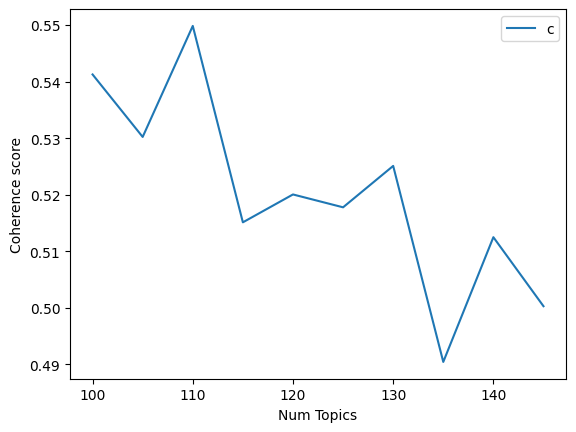

In [33]:
# 최적의 토픽 수 찾기
find_optimal_number_of_topics(dictionary, corpus, data_word)

In [16]:
from konlpy.tag import Mecab
from tqdm import tqdm
import re
from gensim.models.ldamodel import LdaModel
from gensim.models.callbacks import CoherenceMetric
from gensim import corpora
from gensim.models.callbacks import PerplexityMetric
import logging
import pickle
import pyLDAvis.gensim
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [35]:
# find_optimal_number_of_topics(dictionary, corpus, data_word)
# exit()

# noun1
perplexity_logger = PerplexityMetric(corpus=corpus, logger='shell')
coherence_logger = CoherenceMetric(corpus=corpus, coherence="u_mass", logger='shell')

lda_model = LdaModel(corpus, id2word=dictionary, num_topics=110, passes=50,callbacks=[coherence_logger, perplexity_logger])

2023-05-25 15:34:37,735 : INFO : using symmetric alpha at 0.00909090909090909
2023-05-25 15:34:37,736 : INFO : using symmetric eta at 0.00909090909090909
2023-05-25 15:34:37,738 : INFO : using serial LDA version on this node
2023-05-25 15:34:37,855 : INFO : running online (multi-pass) LDA training, 110 topics, 50 passes over the supplied corpus of 49954 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2023-05-25 15:34:37,858 : INFO : PROGRESS: pass 0, at document #2000/49954
2023-05-25 15:34:40,002 : INFO : merging changes from 2000 documents into a model of 49954 documents
2023-05-25 15:34:40,081 : INFO : topic #40 (0.009): 0.009*"대출" + 0.009*"학생" + 0.008*"이사" + 0.006*"삼성전자" + 0.006*"LG디스플레이" + 0.005*"상담" + 0.004*"선발" + 0.004*"전자" + 0.004*"칠판" + 0.004*"협업"
2023-05-25 15:34:40,084 : INFO : topic #32 (0.009): 0.009*"종목" + 0.008*"신용" + 0.007*"호박" + 0.006*"이직" + 0.006*"종자" + 0.005*"대출" 

In [37]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_word, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score (c_v): ', coherence_lda)

# Compute Coherence Score using UMass
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_word, dictionary=dictionary, coherence="u_mass")
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score (u_mass): ', coherence_lda)

2023-05-25 16:25:23,632 : INFO : using ParallelWordOccurrenceAccumulator(processes=9, batch_size=64) to estimate probabilities from sliding windows
2023-05-25 16:25:28,288 : INFO : 1 batches submitted to accumulate stats from 64 documents (8679 virtual)
2023-05-25 16:25:28,291 : INFO : 2 batches submitted to accumulate stats from 128 documents (14162 virtual)
2023-05-25 16:25:28,293 : INFO : 3 batches submitted to accumulate stats from 192 documents (18996 virtual)
2023-05-25 16:25:28,295 : INFO : 4 batches submitted to accumulate stats from 256 documents (22690 virtual)
2023-05-25 16:25:28,296 : INFO : 5 batches submitted to accumulate stats from 320 documents (25669 virtual)
2023-05-25 16:25:28,298 : INFO : 6 batches submitted to accumulate stats from 384 documents (27846 virtual)
2023-05-25 16:25:28,302 : INFO : 7 batches submitted to accumulate stats from 448 documents (33144 virtual)
2023-05-25 16:25:28,307 : INFO : 8 batches submitted to accumulate stats from 512 documents (38802


Coherence Score (c_v):  0.5514861410472426


2023-05-25 16:26:05,022 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2023-05-25 16:26:05,032 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2023-05-25 16:26:05,046 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2023-05-25 16:26:05,060 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2023-05-25 16:26:05,075 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2023-05-25 16:26:05,088 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2023-05-25 16:26:05,101 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2023-05-25 16:26:05,114 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2023-05-25 16:26:05,127 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2023-05-25 16:26:05,140 : INFO : CorpusAccumulator accumulated stats from 10000 documents
2023-05-25 16:26:05,153 : INFO : CorpusAccumulator accumulated stats from 11000 documents
2023-05-25 16:26:05


Coherence Score (u_mass):  -4.747755362596165


In [36]:
# 저장
# pickle.dump(corpus, open('./data/lda/lda_corpus.pkl', 'wb'))
dictionary.save('lda_dictionary(final).gensim')
lda_model.save('lda_model(final).gensim')

2023-05-25 16:25:14,907 : INFO : saving Dictionary object under lda_dictionary(final).gensim, separately None
2023-05-25 16:25:14,947 : INFO : saved lda_dictionary(final).gensim
2023-05-25 16:25:14,949 : INFO : saving LdaState object under lda_model(final).gensim.state, separately None
2023-05-25 16:25:14,967 : INFO : saved lda_model(final).gensim.state
2023-05-25 16:25:14,976 : INFO : saving LdaModel object under lda_model(final).gensim, separately ['expElogbeta', 'sstats']
2023-05-25 16:25:14,977 : INFO : storing np array 'expElogbeta' to lda_model(final).gensim.expElogbeta.npy
2023-05-25 16:25:14,984 : INFO : not storing attribute state
2023-05-25 16:25:14,984 : INFO : not storing attribute dispatcher
2023-05-25 16:25:14,984 : INFO : not storing attribute id2word
2023-05-25 16:25:15,715 : INFO : saved lda_model(final).gensim


In [17]:
from gensim.models import LdaModel

lda_model = LdaModel.load('lda_model(final).gensim')

2023-05-25 16:32:47,527 : INFO : loading LdaModel object from lda_model(final).gensim
2023-05-25 16:32:47,770 : INFO : loading expElogbeta from lda_model(final).gensim.expElogbeta.npy with mmap=None
2023-05-25 16:32:47,775 : INFO : setting ignored attribute state to None
2023-05-25 16:32:47,775 : INFO : setting ignored attribute dispatcher to None
2023-05-25 16:32:47,775 : INFO : setting ignored attribute id2word to None
2023-05-25 16:32:47,776 : INFO : loaded lda_model(final).gensim
2023-05-25 16:32:47,776 : INFO : loading LdaState object from lda_model(final).gensim.state
2023-05-25 16:32:47,784 : INFO : loaded lda_model(final).gensim.state


In [24]:
# pyLDAvis html 저장
lda_visualization = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.save_html(lda_visualization, '뉴스군집화_lda(final).html')

In [ ]:
corpus

In [ ]:
topics = []
for i, doc in enumerate(corpus):
    dist = lda_model.get_document_topics(doc, per_word_topics=False)
    highest_prob_topic = max(dist, key=lambda x: x[1])
    topic, prob = highest_prob_topic
    topics.append([i, topic, prob])
news_df = pd.DataFrame(topics, columns=['row', 'topic', 'prob'])

print(news_df.head())
print(news_df.shape)


In [ ]:
len(df['topic'].unique())

In [20]:
import pandas as pd

# Create an empty DataFrame to store the topics
keyword_newsdf = pd.DataFrame(columns=['Topic ID', 'Words'])

num_topics = 45  # Total number of topics

# Process each topic and add it to the DataFrame
for topic_id in range(num_topics):
    topic_words = lda_model.show_topic(topic_id)
    words = [word for word, _ in topic_words]
    print(words)
    # words_str = [', '.join(words)]
    keyword_newsdf = keyword_newsdf.append({'Topic ID': topic_id + 1, 'Words': words}, ignore_index=True)

# Display the DataFrame
# print(keyword_newsdf)

['훈련', '국방부', '연합', '작전', '무기', '전투기', '폴란드', '공군', '전차', '부대']
['백신', '연구소', '바다', '해양', '소장', '서해', '접종', '바이러스', '해리', '영공']
['위원장', '원장', '리츠', '부장', '동포', '국장', '상임', '통일', 'TV조선', '점수']
['여사', '사과', '김건희', '유족', '성과급', '부인', '피해자들', '사죄', '전두환', '감사']
['애플', '삼성전자', '스마트폰', '기기', '갤럭시', '장비', '메모리', '아이폰', 'SK하이닉스', 'OLED']
['보조금', '공제', '세액', 'IRA', '혜택', '아르헨티나', '세제', '금속', '광물', '조건']
['호주', '풍력', '해상', '플랜트', '이주', '두산', '포르투갈', '바흐', 'HUG', '출장']
['편의점', '점포', '운송', '니다', '통장', '저자', '화물', '출간', '스키', 'GS']
['물류', '수주', '선박', '용지', '창고', '학위', '슈퍼', '발주', '컨테이너', '항만']
['협약', '프로젝트', '베트남', '육성', '중소기업', '활성', '스마트', '인프라', '중소', 'UAE']
['스타트', '창업', '벤처', '테크', '창업자', '벨라루스', '순항', '유치', 'VC', '초기']
['불법', '보안', '단속', '점검', '적발', '사이버', '운전자', '예방', '운전', '사이트']
['패션', '화장품', '디자인', '명품', '시계', '의류', '크림', '구미', '예능', '우유']
['마약', '구속', '지검', '압수수색', '영장', '구속영장', '투약', '청구', '피의자', '소환']
['마스크', '대만', '의무', '해제', '홍콩', '착용', '방역', '확진', '실내', '격리']
['제주', '버스', '참사', '경매'

In [25]:
import pandas as pd

# Create an empty DataFrame to store the topics
topics_df = pd.DataFrame(columns=['Topic ID', 'Words'])

num_topics = 110  # Total number of topics

# Process each topic and add it to the DataFrame
for topic_id in range(num_topics):
    topic_words = lda_model.show_topic(topic_id, topn=50)
    words = [word for word, _ in topic_words]
    print(words)
    # words_str = [', '.join(words)]
    topics_df = topics_df.append({'Topic ID': topic_id + 1, 'Words': words}, ignore_index=True)

# Display the DataFrame
# print(topics_df)

['훈련', '국방부', '연합', '작전', '무기', '전투기', '폴란드', '공군', '전차', '부대', '기지', '미군', '군사', '해군', '무인', '육군', '방위', '전투', '국방', '연습', '체계', '임무', '미사일', '전력', '방어', '병력', '능력', '투입', '수행', '항공기', '전장', '사령관', '군인', '다이', '안보', '위협', '탐지', '사단', '기동', '상륙', '해병대', '화력', '충돌', '운용', '장교', '장비', 'FTX', '침투', '국군', '함정']
['백신', '연구소', '바다', '해양', '소장', '서해', '접종', '바이러스', '해리', '영공', '해경', '인자', '개량', '국립', '발병', '생물', '찰스', '어업', '예방', '갱신', '채취', '어선', '대장', '기원', '확인서', '중량', '해수', '조업', '해역', '해상', '부두', '리보', '제압', '입대', '컬리', '소금', '조성현', '권장', '양말', '사비', '안쪽', '바늘', '세계유산', '유전체', '범죄인', '결론', '불발', '선원', '해양수산부', '주중']
['위원장', '원장', '리츠', '부장', '동포', '국장', '상임', '통일', 'TV조선', '점수', '남용', '부지사', '빌딩', '모금', '성금', '남북', '직권', '화이트', '오피스', '리스트', '과장', '대외', '인상률', '재일', '문건', '작성', '심사', '하위', '승인', '박지원', '지시', '박근혜', '보고서', '방통', '만점', '외무성', '하야시', '조건부', '친분', '방해', '정계', '관여', '분당', '후임', '공실', '관악구', '도봉구', '외무상', '통일부', '상응']
['여사', '사과', '김건희', '유족', '성과급', '부인', '피해자들', '사죄', '전두환',

In [26]:
topics_df.shape

(110, 2)

In [27]:
import pandas as pd

topics = lda_model.print_topics(num_words=100)
topic_data = []

for topic in topics:
    topic_num = topic[0]
    topic_words = topic[1]
    word_list = [word.split('*')[1].strip().replace('"', '') for word in topic_words.split(' + ')]
    topic_data.append((topic_num, word_list))

# pd.DataFrame(topic_data, columns=['Topic Number', 'Words']).head(3)

2023-05-25 16:33:51,438 : INFO : topic #14 (0.009): 0.080*"마스크" + 0.072*"대만" + 0.059*"의무" + 0.058*"해제" + 0.056*"홍콩" + 0.052*"착용" + 0.047*"방역" + 0.031*"확진" + 0.025*"실내" + 0.018*"격리" + 0.014*"총통" + 0.013*"대중교통" + 0.012*"유행" + 0.011*"본토" + 0.011*"개방" + 0.010*"약국" + 0.010*"차이" + 0.010*"WHO" + 0.010*"감염병" + 0.008*"SCMP" + 0.007*"두기" + 0.006*"비상사태" + 0.006*"본부" + 0.006*"누적" + 0.006*"중대" + 0.006*"일평균" + 0.005*"지침" + 0.005*"전면" + 0.005*"세계보건기구" + 0.005*"팬데믹" + 0.005*"버스" + 0.005*"실외" + 0.005*"단축" + 0.004*"사우스차이나모닝포스트" + 0.004*"일상" + 0.004*"중앙재난안전대책본부" + 0.004*"사이판" + 0.004*"대본" + 0.004*"머독" + 0.004*"자율" + 0.004*"이카" + 0.004*"거리" + 0.004*"경유" + 0.004*"안내문" + 0.004*"항공편" + 0.003*"캘리포니아" + 0.003*"미야" + 0.003*"복장" + 0.003*"차이잉원" + 0.003*"중남미" + 0.003*"변이" + 0.003*"전인" + 0.003*"헨리" + 0.003*"지하철" + 0.003*"양안" + 0.003*"종료" + 0.003*"타이베이" + 0.003*"경계" + 0.003*"단장" + 0.003*"텐센트" + 0.003*"서약" + 0.003*"하태경" + 0.003*"질병" + 0.003*"시점" + 0.003*"LA" + 0.003*"폐지" + 0.003*"주간" + 0.003*"사관학교" + 0.002*"자문" + 0.0

In [28]:
import pickle

with open("final_keyword(최종).pkl","rb") as f:
    keyword_list = pickle.load(f)

In [29]:
job_list = ['sales', 'rnd', 'media', 'design', 'finance', 'marketing','promotion',
            'management', 'it','product']

In [48]:
# keyword_list['finance'] += ['대출', '이자', '보험', '신용', '예금', '가입', '보증', '상환', '한도', '저축', '물가', '지수', '증시', '인플레이션', '환율']

In [30]:
!pip install nltk

In [31]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity

In [33]:
import pandas as pd
df = pd.DataFrame(index=range(0, 110), columns=['title', 'job', 'job_index', 'cos_sim'])
print(df.shape)
df.head(3)

(110, 4)


,title,job,job_index,cos_sim
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN


In [34]:
import ast

In [35]:
# 뉴스와 직무 키워드 간의 유사도 계산
def calculate_similarity(news_topic, job_keywords):
    # 토큰화 및 불용어 처리
    # stop_words = set(stopwords.words('english'))  # 불용어 처리를 위해 영어 불용어 사용
    # news_tokens = [word.lower() for word in word_tokenize(news_topic) if word.isalnum() and word.lower()]
    
    # 직무 키워드 각각과의 유사도 계산
    similarities = []
    for keyword in job_keywords:
        # keyword_tokens = [word.lower() for word in word_tokenize(keyword) if word.isalnum() and word.lower()]
        # news_topic = [word for word in news_topic if word not in stopwords]
        # print(type(news_topic))
        # print(type(job_keywords))
        all_tokens = news_topic + job_keywords  # 뉴스와 직무 키워드의 모든 고유 토큰

        vector1 = [1 if token in news_topic else 0 for token in all_tokens]  # 뉴스의 토큰을 벡터로 표현
        vector2 = [1 if token in job_keywords else 0 for token in all_tokens]  # 직무 키워드의 토큰을 벡터로 표현

        similarity = cosine_similarity([vector1], [vector2])[0][0]  # 코사인 유사도 계산

        similarities.append((keyword, similarity))
    
    return similarities

# 유사도 계산 결과 출력
for i in range(0, len(topics_df)):
  print("=================",i,"=================")
  cos_simlist = []
  # 뉴스의 주요 토픽
  # news_topic = ast.literal_eval(topics_df['Words'][i])
  news_topic =topics_df['Words'][i]

  for job in job_list:
    # 직무 키워드 리스트
    job_keywords = keyword_list[job]
    similarities = calculate_similarity(news_topic, job_keywords)
    similarities.sort(key=lambda x: x[1], reverse=True)  # 유사도에 따라 정렬
    cos_simlist.append(similarities[0][1])
  news_job = job_list[np.argmax(cos_simlist)]
  news_job_idx = np.argmax(cos_simlist)
  if sum(cos_simlist) == 0:
    news_job = None
    news_job_idx = None
    
  print(news_topic[:10], news_job, cos_simlist)
  df.iloc[i] = [news_topic[:10], news_job, news_job_idx, cos_simlist]

================= 0 =================
['훈련', '국방부', '연합', '작전', '무기', '전투기', '폴란드', '공군', '전차', '부대'] product [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020591219099576986]
================= 1 =================
['백신', '연구소', '바다', '해양', '소장', '서해', '접종', '바이러스', '해리', '영공'] rnd [0.0, 0.040615940264474716, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
================= 2 =================
['위원장', '원장', '리츠', '부장', '동포', '국장', '상임', '통일', 'TV조선', '점수'] None [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
================= 3 =================
['여사', '사과', '김건희', '유족', '성과급', '부인', '피해자들', '사죄', '전두환', '감사'] finance [0.0, 0.0, 0.0, 0.0, 0.02059012785608277, 0.0, 0.0, 0.0, 0.0, 0.0]
================= 4 =================
['애플', '삼성전자', '스마트폰', '기기', '갤럭시', '장비', '메모리', '아이폰', 'SK하이닉스', 'OLED'] product [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03695948573450952, 0.0, 0.0, 0.05846637049735538]
================= 5 =================
['보조금', '공제', '세액', 'IRA', '혜택', '아르헨티나', '세제', '금속', '광물', '조건'] prod

KeyboardInterrupt: 

In [85]:
df.head()

,title,job,job_index,cos_sim
0,"[한경, 전당, 지지, 당원, 대회, 김기현, 총선, 주자, 모임, 지도부]",None,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[마스크, 의무, 착용, 방역, 해제, 예방, 확진, 실내, 감염, 보건]",None,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[AI, 스타트, 디지털, 인공지능, 이용자, 솔루션, 구글, 스마트, 네이버, 광고]",it,8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.06467357874979235,..."
3,"[수출, 협약, 원전, 체결, 건설, 수소, UAE, 물류, 수주, 해양]",rnd,1,"[0.0, 0.07881104062391008, 0.0, 0.0, 0.0, 0.0,..."
4,"[매장, 구매, 난방, 할인, 식품, 유통, 편의점, 메뉴, 선물, 카페]",marketing,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.046731012841003686..."


In [63]:
final_keyword = ['product', 'it', 'management', 'finance', 'promotion', 'sales', 'marketing']

In [87]:
for keyword in job_list:
    print(keyword,df[df['job'] == keyword].index)

sales Int64Index([], dtype='int64')
rnd Int64Index([3, 11, 18], dtype='int64')
media Int64Index([6, 16, 17, 33, 36, 39], dtype='int64')
design Int64Index([26], dtype='int64')
finance Int64Index([9, 13, 21, 24, 35, 40], dtype='int64')
marketing Int64Index([4, 7], dtype='int64')
promotion Int64Index([28, 31, 41, 44], dtype='int64')
management Int64Index([29, 43], dtype='int64')
it Int64Index([2, 38], dtype='int64')
product Int64Index([8, 12, 23, 34], dtype='int64')


In [133]:
0 1 5 10 14 15 19 20 22 25 27 30 32 37 42

,title,job,job_index,cos_sim
0,"[한경, 전당, 지지, 당원, 대회, 김기현, 총선, 주자, 모임, 지도부]",None,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[마스크, 의무, 착용, 방역, 해제, 예방, 확진, 실내, 감염, 보건]",None,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[AI, 스타트, 디지털, 인공지능, 이용자, 솔루션, 구글, 스마트, 네이버, 광고]",it,8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.06467357874979235,..."
3,"[수출, 협약, 원전, 체결, 건설, 수소, UAE, 물류, 수주, 해양]",rnd,1,"[0.0, 0.07881104062391008, 0.0, 0.0, 0.0, 0.0,..."
4,"[매장, 구매, 난방, 할인, 식품, 유통, 편의점, 메뉴, 선물, 카페]",marketing,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.046731012841003686..."
5,"[학교, 학생, 대회, 교사, 응답, 인구, 교육청, FC, 여론, 지지]",None,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,"[로봇, 프로, 트럼프, 실험, 크기, 프리, 스티, 문화재, 탱크, 비만]",media,2,"[0.0, 0.0, 0.027610512218752745, 0.0, 0.0, 0.0..."
7,"[유치, 부산, com, 협회, 벤처, 스타트, 포럼, 중소, 간담회, 홍보]",marketing,5,"[0.0, 0.0, 0.0, 0.025987726945541828, 0.0, 0.0..."
8,"[발견, 한화, 포르투갈, 플라스틱, 재활용, 봉사, 실종, 화학, 하이브리드, 시인]",product,9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,"[펀드, 상장, 지분, 주식, SM, 주주, 인수, 카카오, 발행, 투자자]",finance,4,"[0.0, 0.0, 0.027610512218752745, 0.0, 0.078386..."


In [77]:
cluster1_result['row'] = cluster1_result.index

In [79]:
df1 = pd.merge(cluster1_result, news_df, on=['row'])
# filtered_df = df1[df1['topic'].isin(news_idx)]

In [88]:
df1

,TITLE,DATE,PRESS,REPORTER,CONTENT,noun,noun2,noun3,row,topic,prob
0,"'만우절같은 하루'...전국이 산불로 홍역, 화재 20여건 발생",2023-04-01 22:28:41,머니투데이,배한님 기자,\n\t\t\t산림청에 신고된 화재 16건 달해…전국에 소각산불 특보 발령\n\n\...,만우절 하루 전국 산불 홍역 화재 여건 발생,산림청 신고 화재 전국 소각 산불 특보 발령 오후 전남 해남군 옥천면 야산 발생 산...,"[산림청, 신고, 화재, 전국, 소각, 산불, 특보, 발령, 오후, 전남, 해남군,...",0,34,0.812360
1,"강남 한복판 ""살려주세요""…40대女 납치·살해범들 구속영장",2023-04-01 22:17:32,머니투데이,김지은 기자,\n\n\n\n\n납치 용의자들이 지난달 29일 밤 11시46분쯤 서울 역삼동의 한...,강남 한복판 납치 살해범 구속영장,납치 용의자 지난달 서울 역삼동 아파트 입구 피해 여성 차량 납치 영상 독자 제공 ...,"[납치, 용의자, 지난달, 서울, 역삼동, 아파트, 입구, 피해, 여성, 차량, 납...",1,43,0.650595
2,"주키니 호박의 배신…미승인 유전자 검출, 식약처 2개 제품 압류",2023-04-01 21:21:39,머니투데이,지영호 기자,\n\n\n\n\n국내에서 생산된 주키니 호박 종자 일부가 승인되지 않은 유전자 변...,호박 배신 승인 유전자 검출 제품 압류,국내 생산 호박 종자 일부 승인 유전자 변형 생물체 확인 긴급 대응 사진 호박 식품...,"[국내, 생산, 호박, 종자, 일부, 승인, 유전자, 변형, 생물체, 확인, 긴급,...",2,4,0.432887
3,"""폭탄 들고 서문시장 간다""…尹 겨냥한 테러 암시글에 경찰 조사 중",2023-04-01 21:13:25,머니투데이,배한님 기자,\n\n\n\n\n윤석열 대통령과 부인 김건희 여사가 1일 대구 서문시장에서 열린 ...,폭탄 서문시장 간다 겨냥 테러 암시 경찰 조사,윤석열 대통령 부인 김건희 여사 대구 서문시장 서문시장 주년 기념식 참석 시민 인사...,"[윤석열, 대통령, 부인, 김건희, 여사, 대구, 서문시장, 서문시장, 주년, 기념...",3,0,0.183114
4,"1061회 로또, 1등 24억원씩 11명이 받는다…2등 99명",2023-04-01 21:04:18,머니투데이,배한님 기자,\n\n\n\n\n/사진=동행복권 홈페이지 갈무리로또복권을 운영 중인 동행복권은 제...,NaN,사진 동행 복권 홈페이지 갈무리 복권 운영 동행 복권 복권 추첨 번호 보너스 번호 ...,"[사진, 동행, 복권, 홈페이지, 갈무리, 복권, 운영, 동행, 복권, 복권, 추첨...",4,25,0.948246
...,...,...,...,...,...,...,...,...,...,...,...
95692,[포토] '2022년 하반기 더펜 베스트 필진' 박영실 라이프이스트,2023-01-18 16:43:05,한국경제,변성현 기자,\n\n\n\n\n2022년 하반기 '더펜 베스트 필진 시상식'이 18일 오전 서울...,포토 하반기 베스트 필진 박영 라이프 이스트,하반기 베스트 필진 시상식 오전 서울 청파동 한국경제신문 빌딩 박영 라이프 이스트 ...,"[하반기, 베스트, 필진, 시상식, 오전, 서울, 청파동, 한국경제신문, 빌딩, 박...",95761,42,0.535212
95693,"경북경제진흥원, 경북 세일페스타 1조 달성 목표로 뛴다.",2023-01-18 16:43:04,한국경제,오경묵 기자,\n\n\n\n\n경상북도경제진흥원은 올해 ‘라인셀러 허브로서 경북 세일페스타 매출...,경북 경제 진흥원 경북 세일 페스 달성 목표,경상북도 경제 진흥원 올해 라인 셀러 허브 경북 세일 페스 매출 조원 달성 목표 경...,"[경상북도, 경제, 진흥원, 올해, 라인, 셀러, 허브, 경북, 세일, 페스, 매출...",95762,43,0.376921
95694,[포토] '2022년 하반기 더펜 베스트 필진' 조재영 머니이스트,2023-01-18 16:42:03,한국경제,변성현 기자,\n\n\n\n\n2022년 하반기 '더펜 베스트 필진 시상식'이 18일 오전 서울...,포토 하반기 베스트 필진 조재영 머니 이스트,하반기 베스트 필진 시상식 오전 서울 청파동 한국경제신문 빌딩 조재영 머니 이스트 ...,"[하반기, 베스트, 필진, 시상식, 오전, 서울, 청파동, 한국경제신문, 빌딩, 조...",95763,21,0.423491
95695,[포토] '2022년 하반기 더펜 베스트 필진' 도정환 머니이스트,2023-01-18 16:41:05,한국경제,변성현 기자,\n\n\n\n\n2022년 하반기 '더펜 베스트 필진 시상식'이 18일 오전 서울...,포토 하반기 베스트 필진 정환 머니 이스트,하반기 베스트 필진 시상식 오전 서울 청파동 한국경제신문 빌딩 정환 머니 이스트 오...,"[하반기, 베스트, 필진, 시상식, 오전, 서울, 청파동, 한국경제신문, 빌딩, 정...",95764,13,0.345367


In [ ]:
  sales Int64Index([], dtype='int64')
1 rnd Int64Index([3, 11, 18], dtype='int64') 
2 media Int64Index([6, 16, 17, 33, 36, 39], dtype='int64')
3 design Int64Index([26], dtype='int64')
4 finance Int64Index([9, 13, 21, 24, 35, 40], dtype='int64')
5 marketing Int64Index([4, 7], dtype='int64')
6 promotion Int64Index([28, 31, 41, 44], dtype='int64')
7 management Int64Index([29, 43], dtype='int64')
8 it Int64Index([2, 38], dtype='int64')
9 product Int64Index([8, 12, 23, 34], dtype='int64')
0

In [105]:
df1['y']=None

In [125]:
df['job'][1]

In [120]:
print(df[df['job'] == None].index)

Int64Index([], dtype='int64')


In [143]:
df1['y'].unique()

array([9, 7, 5, 0, 4, 2, 6, 1, 3, 8], dtype=object)

In [142]:
df1.loc[df1['topic']==3, 'y'] = 1
df1.loc[df1['topic']==11, 'y'] = 1
df1.loc[df1['topic']==18, 'y'] = 1

df1.loc[df1['topic']==6, 'y'] = 2
df1.loc[df1['topic']==16, 'y'] = 2
df1.loc[df1['topic']==17, 'y'] = 2
df1.loc[df1['topic']==33, 'y'] = 2
df1.loc[df1['topic']==36, 'y'] = 2
df1.loc[df1['topic']==39, 'y'] = 2


df1.loc[df1['topic']==26, 'y'] = 3

df1.loc[df1['topic']==9, 'y'] = 4
df1.loc[df1['topic']==13, 'y'] = 4
df1.loc[df1['topic']==21, 'y'] = 4
df1.loc[df1['topic']==24, 'y'] = 4
df1.loc[df1['topic']==35, 'y'] = 4
df1.loc[df1['topic']==40, 'y'] = 4

df1.loc[df1['topic']==4, 'y'] = 5
df1.loc[df1['topic']==7, 'y'] = 5

df1.loc[df1['topic']==28, 'y'] = 6
df1.loc[df1['topic']==31, 'y'] = 6
df1.loc[df1['topic']==41, 'y'] = 6
df1.loc[df1['topic']==44, 'y'] = 6

df1.loc[df1['topic']==29, 'y'] = 7
df1.loc[df1['topic']==43, 'y'] = 7

df1.loc[df1['topic']==2, 'y'] = 8
df1.loc[df1['topic']==38, 'y'] = 8

df1.loc[df1['topic']==8, 'y'] = 9
df1.loc[df1['topic']==12, 'y'] = 9
df1.loc[df1['topic']==23, 'y'] = 9
df1.loc[df1['topic']==34, 'y'] = 9

df1.loc[df1['topic']==0, 'y'] = 0
df1.loc[df1['topic']==1, 'y'] = 0
df1.loc[df1['topic']==5, 'y'] = 0
df1.loc[df1['topic']==10, 'y'] = 0
df1.loc[df1['topic']==14, 'y'] = 0
df1.loc[df1['topic']==15, 'y'] = 0
df1.loc[df1['topic']==19, 'y'] = 0
df1.loc[df1['topic']==20, 'y'] = 0
df1.loc[df1['topic']==22, 'y'] = 0
df1.loc[df1['topic']==25, 'y'] = 0
df1.loc[df1['topic']==27, 'y'] = 0
df1.loc[df1['topic']==30, 'y'] = 0
df1.loc[df1['topic']==32, 'y'] = 0
df1.loc[df1['topic']==37, 'y'] = 0
df1.loc[df1['topic']==42, 'y'] = 0


In [138]:
df1

,TITLE,DATE,PRESS,REPORTER,CONTENT,noun,noun2,noun3,row,topic,prob,y
0,"'만우절같은 하루'...전국이 산불로 홍역, 화재 20여건 발생",2023-04-01 22:28:41,머니투데이,배한님 기자,\n\t\t\t산림청에 신고된 화재 16건 달해…전국에 소각산불 특보 발령\n\n\...,만우절 하루 전국 산불 홍역 화재 여건 발생,산림청 신고 화재 전국 소각 산불 특보 발령 오후 전남 해남군 옥천면 야산 발생 산...,"[산림청, 신고, 화재, 전국, 소각, 산불, 특보, 발령, 오후, 전남, 해남군,...",0,34,0.812360,None
1,"강남 한복판 ""살려주세요""…40대女 납치·살해범들 구속영장",2023-04-01 22:17:32,머니투데이,김지은 기자,\n\n\n\n\n납치 용의자들이 지난달 29일 밤 11시46분쯤 서울 역삼동의 한...,강남 한복판 납치 살해범 구속영장,납치 용의자 지난달 서울 역삼동 아파트 입구 피해 여성 차량 납치 영상 독자 제공 ...,"[납치, 용의자, 지난달, 서울, 역삼동, 아파트, 입구, 피해, 여성, 차량, 납...",1,43,0.650595,None
2,"주키니 호박의 배신…미승인 유전자 검출, 식약처 2개 제품 압류",2023-04-01 21:21:39,머니투데이,지영호 기자,\n\n\n\n\n국내에서 생산된 주키니 호박 종자 일부가 승인되지 않은 유전자 변...,호박 배신 승인 유전자 검출 제품 압류,국내 생산 호박 종자 일부 승인 유전자 변형 생물체 확인 긴급 대응 사진 호박 식품...,"[국내, 생산, 호박, 종자, 일부, 승인, 유전자, 변형, 생물체, 확인, 긴급,...",2,4,0.432887,None
3,"""폭탄 들고 서문시장 간다""…尹 겨냥한 테러 암시글에 경찰 조사 중",2023-04-01 21:13:25,머니투데이,배한님 기자,\n\n\n\n\n윤석열 대통령과 부인 김건희 여사가 1일 대구 서문시장에서 열린 ...,폭탄 서문시장 간다 겨냥 테러 암시 경찰 조사,윤석열 대통령 부인 김건희 여사 대구 서문시장 서문시장 주년 기념식 참석 시민 인사...,"[윤석열, 대통령, 부인, 김건희, 여사, 대구, 서문시장, 서문시장, 주년, 기념...",3,0,0.183114,None
4,"1061회 로또, 1등 24억원씩 11명이 받는다…2등 99명",2023-04-01 21:04:18,머니투데이,배한님 기자,\n\n\n\n\n/사진=동행복권 홈페이지 갈무리로또복권을 운영 중인 동행복권은 제...,NaN,사진 동행 복권 홈페이지 갈무리 복권 운영 동행 복권 복권 추첨 번호 보너스 번호 ...,"[사진, 동행, 복권, 홈페이지, 갈무리, 복권, 운영, 동행, 복권, 복권, 추첨...",4,25,0.948246,None
...,...,...,...,...,...,...,...,...,...,...,...,...
95692,[포토] '2022년 하반기 더펜 베스트 필진' 박영실 라이프이스트,2023-01-18 16:43:05,한국경제,변성현 기자,\n\n\n\n\n2022년 하반기 '더펜 베스트 필진 시상식'이 18일 오전 서울...,포토 하반기 베스트 필진 박영 라이프 이스트,하반기 베스트 필진 시상식 오전 서울 청파동 한국경제신문 빌딩 박영 라이프 이스트 ...,"[하반기, 베스트, 필진, 시상식, 오전, 서울, 청파동, 한국경제신문, 빌딩, 박...",95761,42,0.535212,None
95693,"경북경제진흥원, 경북 세일페스타 1조 달성 목표로 뛴다.",2023-01-18 16:43:04,한국경제,오경묵 기자,\n\n\n\n\n경상북도경제진흥원은 올해 ‘라인셀러 허브로서 경북 세일페스타 매출...,경북 경제 진흥원 경북 세일 페스 달성 목표,경상북도 경제 진흥원 올해 라인 셀러 허브 경북 세일 페스 매출 조원 달성 목표 경...,"[경상북도, 경제, 진흥원, 올해, 라인, 셀러, 허브, 경북, 세일, 페스, 매출...",95762,43,0.376921,None
95694,[포토] '2022년 하반기 더펜 베스트 필진' 조재영 머니이스트,2023-01-18 16:42:03,한국경제,변성현 기자,\n\n\n\n\n2022년 하반기 '더펜 베스트 필진 시상식'이 18일 오전 서울...,포토 하반기 베스트 필진 조재영 머니 이스트,하반기 베스트 필진 시상식 오전 서울 청파동 한국경제신문 빌딩 조재영 머니 이스트 ...,"[하반기, 베스트, 필진, 시상식, 오전, 서울, 청파동, 한국경제신문, 빌딩, 조...",95763,21,0.423491,None
95695,[포토] '2022년 하반기 더펜 베스트 필진' 도정환 머니이스트,2023-01-18 16:41:05,한국경제,변성현 기자,\n\n\n\n\n2022년 하반기 '더펜 베스트 필진 시상식'이 18일 오전 서울...,포토 하반기 베스트 필진 정환 머니 이스트,하반기 베스트 필진 시상식 오전 서울 청파동 한국경제신문 빌딩 정환 머니 이스트 오...,"[하반기, 베스트, 필진, 시상식, 오전, 서울, 청파동, 한국경제신문, 빌딩, 정...",95764,13,0.345367,None


In [151]:
df1.to_csv('news_LDA(0525_final).csv')

In [145]:
df['job'].value_counts()

media         6
finance       6
product       4
promotion     4
rnd           3
it            2
marketing     2
management    2
design        1
Name: job, dtype: int64

In [146]:
import pandas as pd

topics = lda_model.print_topics(num_words=20)
topic_data = []

for topic in topics:
    topic_num = topic[0]
    topic_words = topic[1]
    word_list = [word.split('*')[1].strip().replace('"', '') for word in topic_words.split(' + ')]
    topic_data.append((topic_num, word_list))

df_topics = pd.DataFrame(topic_data, columns=['Topic Number', 'Words'])

2023-05-25 14:23:53,655 : INFO : topic #17 (0.022): 0.039*"음악" + 0.031*"공연" + 0.016*"제작" + 0.015*"가상" + 0.014*"연주" + 0.013*"롯데" + 0.013*"아티스트" + 0.012*"웹툰" + 0.011*"MBC" + 0.011*"무대" + 0.011*"IP" + 0.011*"화폐" + 0.010*"앨범" + 0.010*"콘서트" + 0.008*"데뷔" + 0.008*"긱스" + 0.008*"메디톡스" + 0.008*"오케스트라" + 0.008*"애니메이션" + 0.008*"저작권"
2023-05-25 14:23:53,656 : INFO : topic #8 (0.022): 0.029*"발견" + 0.020*"한화" + 0.013*"포르투갈" + 0.012*"플라스틱" + 0.011*"재활용" + 0.009*"봉사" + 0.009*"실종" + 0.008*"화학" + 0.008*"하이브리드" + 0.008*"시인" + 0.007*"수색" + 0.007*"대우" + 0.007*"폐기물" + 0.007*"광산" + 0.007*"종이" + 0.007*"이스라엘" + 0.006*"임플란트" + 0.006*"유해" + 0.006*"소재" + 0.006*"작업"
2023-05-25 14:23:53,657 : INFO : topic #27 (0.022): 0.017*"시위" + 0.010*"낙찰" + 0.010*"집회" + 0.008*"특검" + 0.008*"정권" + 0.007*"폭탄" + 0.007*"압수수색" + 0.006*"문재인" + 0.006*"경매" + 0.006*"탄압" + 0.006*"조작" + 0.006*"대변인" + 0.005*"사무실" + 0.005*"평화" + 0.005*"고발" + 0.005*"대북" + 0.005*"보복" + 0.005*"언론" + 0.005*"일당" + 0.004*"관여"
2023-05-25 14:23:53,658 : INFO : topic #

In [148]:
df_topics['직무'] = df['job']

In [150]:
df1

,TITLE,DATE,PRESS,REPORTER,CONTENT,noun,noun2,noun3,row,topic,prob,y
0,"'만우절같은 하루'...전국이 산불로 홍역, 화재 20여건 발생",2023-04-01 22:28:41,머니투데이,배한님 기자,\n\t\t\t산림청에 신고된 화재 16건 달해…전국에 소각산불 특보 발령\n\n\...,만우절 하루 전국 산불 홍역 화재 여건 발생,산림청 신고 화재 전국 소각 산불 특보 발령 오후 전남 해남군 옥천면 야산 발생 산...,"[산림청, 신고, 화재, 전국, 소각, 산불, 특보, 발령, 오후, 전남, 해남군,...",0,34,0.812360,9
1,"강남 한복판 ""살려주세요""…40대女 납치·살해범들 구속영장",2023-04-01 22:17:32,머니투데이,김지은 기자,\n\n\n\n\n납치 용의자들이 지난달 29일 밤 11시46분쯤 서울 역삼동의 한...,강남 한복판 납치 살해범 구속영장,납치 용의자 지난달 서울 역삼동 아파트 입구 피해 여성 차량 납치 영상 독자 제공 ...,"[납치, 용의자, 지난달, 서울, 역삼동, 아파트, 입구, 피해, 여성, 차량, 납...",1,43,0.650595,7
2,"주키니 호박의 배신…미승인 유전자 검출, 식약처 2개 제품 압류",2023-04-01 21:21:39,머니투데이,지영호 기자,\n\n\n\n\n국내에서 생산된 주키니 호박 종자 일부가 승인되지 않은 유전자 변...,호박 배신 승인 유전자 검출 제품 압류,국내 생산 호박 종자 일부 승인 유전자 변형 생물체 확인 긴급 대응 사진 호박 식품...,"[국내, 생산, 호박, 종자, 일부, 승인, 유전자, 변형, 생물체, 확인, 긴급,...",2,4,0.432887,5
3,"""폭탄 들고 서문시장 간다""…尹 겨냥한 테러 암시글에 경찰 조사 중",2023-04-01 21:13:25,머니투데이,배한님 기자,\n\n\n\n\n윤석열 대통령과 부인 김건희 여사가 1일 대구 서문시장에서 열린 ...,폭탄 서문시장 간다 겨냥 테러 암시 경찰 조사,윤석열 대통령 부인 김건희 여사 대구 서문시장 서문시장 주년 기념식 참석 시민 인사...,"[윤석열, 대통령, 부인, 김건희, 여사, 대구, 서문시장, 서문시장, 주년, 기념...",3,0,0.183114,0
4,"1061회 로또, 1등 24억원씩 11명이 받는다…2등 99명",2023-04-01 21:04:18,머니투데이,배한님 기자,\n\n\n\n\n/사진=동행복권 홈페이지 갈무리로또복권을 운영 중인 동행복권은 제...,NaN,사진 동행 복권 홈페이지 갈무리 복권 운영 동행 복권 복권 추첨 번호 보너스 번호 ...,"[사진, 동행, 복권, 홈페이지, 갈무리, 복권, 운영, 동행, 복권, 복권, 추첨...",4,25,0.948246,0
...,...,...,...,...,...,...,...,...,...,...,...,...
95692,[포토] '2022년 하반기 더펜 베스트 필진' 박영실 라이프이스트,2023-01-18 16:43:05,한국경제,변성현 기자,\n\n\n\n\n2022년 하반기 '더펜 베스트 필진 시상식'이 18일 오전 서울...,포토 하반기 베스트 필진 박영 라이프 이스트,하반기 베스트 필진 시상식 오전 서울 청파동 한국경제신문 빌딩 박영 라이프 이스트 ...,"[하반기, 베스트, 필진, 시상식, 오전, 서울, 청파동, 한국경제신문, 빌딩, 박...",95761,42,0.535212,0
95693,"경북경제진흥원, 경북 세일페스타 1조 달성 목표로 뛴다.",2023-01-18 16:43:04,한국경제,오경묵 기자,\n\n\n\n\n경상북도경제진흥원은 올해 ‘라인셀러 허브로서 경북 세일페스타 매출...,경북 경제 진흥원 경북 세일 페스 달성 목표,경상북도 경제 진흥원 올해 라인 셀러 허브 경북 세일 페스 매출 조원 달성 목표 경...,"[경상북도, 경제, 진흥원, 올해, 라인, 셀러, 허브, 경북, 세일, 페스, 매출...",95762,43,0.376921,7
95694,[포토] '2022년 하반기 더펜 베스트 필진' 조재영 머니이스트,2023-01-18 16:42:03,한국경제,변성현 기자,\n\n\n\n\n2022년 하반기 '더펜 베스트 필진 시상식'이 18일 오전 서울...,포토 하반기 베스트 필진 조재영 머니 이스트,하반기 베스트 필진 시상식 오전 서울 청파동 한국경제신문 빌딩 조재영 머니 이스트 ...,"[하반기, 베스트, 필진, 시상식, 오전, 서울, 청파동, 한국경제신문, 빌딩, 조...",95763,21,0.423491,4
95695,[포토] '2022년 하반기 더펜 베스트 필진' 도정환 머니이스트,2023-01-18 16:41:05,한국경제,변성현 기자,\n\n\n\n\n2022년 하반기 '더펜 베스트 필진 시상식'이 18일 오전 서울...,포토 하반기 베스트 필진 정환 머니 이스트,하반기 베스트 필진 시상식 오전 서울 청파동 한국경제신문 빌딩 정환 머니 이스트 오...,"[하반기, 베스트, 필진, 시상식, 오전, 서울, 청파동, 한국경제신문, 빌딩, 정...",95764,13,0.345367,4


In [128]:
import pandas as pd

topics = lda_model.print_topics(num_words=10)
topic_data = []

for topic in topics:
    topic_num = topic[0]
    topic_words = topic[1]
    word_list = [word.split('*')[1].strip().replace('"', '') for word in topic_words.split(' + ')]
    topic_data.append((topic_num, word_list))

df_topics = pd.DataFrame(topic_data, columns=['topic', 'Words'])

2023-05-22 01:20:18,113 : INFO : topic #18 (0.022): 0.046*"바이오" + 0.027*"임상" + 0.021*"치료제" + 0.021*"gt" + 0.020*"lt" + 0.019*"의약품" + 0.015*"신약" + 0.015*"브라질" + 0.015*"허가" + 0.015*"객원"
2023-05-22 01:20:18,127 : INFO : topic #34 (0.022): 0.022*"공항" + 0.020*"인천" + 0.015*"관광" + 0.015*"여행" + 0.014*"화재" + 0.014*"제주" + 0.011*"소방" + 0.010*"관광객" + 0.009*"도로" + 0.009*"외국인"
2023-05-22 01:20:18,130 : INFO : topic #38 (0.022): 0.036*"게임" + 0.028*"콘텐츠" + 0.027*"보험" + 0.023*"반려" + 0.023*"동물" + 0.013*"OTT" + 0.013*"토큰" + 0.013*"블록체인" + 0.011*"가입자" + 0.010*"NFT"
2023-05-22 01:20:18,132 : INFO : topic #36 (0.022): 0.029*"영화" + 0.023*"서울시" + 0.020*"배우" + 0.019*"넷플릭스" + 0.017*"지하철" + 0.016*"버스" + 0.015*"보배" + 0.014*"장애인" + 0.013*"드라마" + 0.012*"공사"
2023-05-22 01:20:18,134 : INFO : topic #1 (0.022): 0.039*"마스크" + 0.030*"의무" + 0.029*"착용" + 0.023*"방역" + 0.023*"해제" + 0.021*"예방" + 0.019*"확진" + 0.017*"실내" + 0.017*"감염" + 0.017*"보건"
2023-05-22 01:20:18,137 : INFO : topic #6 (0.022): 0.054*"로봇" + 0.024*"프로" + 0.018

In [135]:
df_topics['job_idx'] = df['job_index']
df_topics['job'] = df['job']
df_topics

,topic,Words,job_idx,job
0,18,"[바이오, 임상, 치료제, gt, lt, 의약품, 신약, 브라질, 허가, 객원]",None,None
1,34,"[공항, 인천, 관광, 여행, 화재, 제주, 소방, 관광객, 도로, 외국인]",None,None
2,38,"[게임, 콘텐츠, 보험, 반려, 동물, OTT, 토큰, 블록체인, 가입자, NFT]",8,it
3,36,"[영화, 서울시, 배우, 넷플릭스, 지하철, 버스, 보배, 장애인, 드라마, 공사]",1,rnd
4,1,"[마스크, 의무, 착용, 방역, 해제, 예방, 확진, 실내, 감염, 보건]",9,product
5,6,"[로봇, 프로, 트럼프, 실험, 크기, 프리, 스티, 문화재, 탱크, 비만]",None,None
6,32,"[전세, 공시, 임대, 사기, 지점장, 보증금, 매매, 법인, 월세, 매물]",2,media
7,43,"[선고, 재판, 범죄, 부장, 피해자, 범행, 징역, 구속, 처벌, 형사]",5,marketing
8,20,"[북한, 미사일, 훈련, 발사, 비행, 국방부, 군사, 도발, 탄도, 위협]",9,product
9,42,"[아이, 아동, 남성, 부모, 기사, SNS, 부부, 자녀, 결혼, 커뮤니티]",4,finance


In [53]:
df.to_csv('news_topic_df.csv', encoding='utf-8')

In [58]:
df_topics.to_csv('news_topic_df.csv', encoding='utf-8')

In [3]:
pd.read_csv('news_topic_df.csv', encoding='utf-8')

,Unnamed: 0,Topic Number,Words
0,0,20,"['수출', '협약', '탄소', '조성', '수소', '육성', '프로젝트', '..."
1,1,2,"['가구', '분양', '청약', '단지', '입주', '전용', '물량', '집값..."
2,2,5,"['SVB', '파산', '스위스', '가스', '요금', '실리콘밸리', '뉴욕'..."
3,3,17,"['부산', '대구', '경북', '제주', '마을', '기온', '광주', '경남..."
4,4,16,"['식품', '편의점', '음식', '배달', '유통', '메뉴', '플라스틱', ..."
5,5,13,"['SM', '카카오', '인수', '지분', '하이브', '주주', '공개매수',..."
6,6,15,"['대출', '전세', '소득', '신용', '이자', '가입', '보험', '보증..."
7,7,3,"['공사', '주민', '서울시', '건물', '화재', '공공', '건설', '산..."
8,8,6,"['노조', '고용', '근로', '노동', '연금', '근로자', '개혁', '재..."
9,9,0,"['주식', '투자자', '상장', '펀드', '수익률', '채권', '매수', '..."


In [49]:
pd.read_csv('LDA_topics_300.csv', encoding='utf-8')

,Unnamed: 0,Topic Number,Words
0,0,32,"['등급', '화장품', '롯데', '쌍방울', '점수', '연휴', '입찰', '..."
1,1,20,"['수출', '협약', '탄소', '조성', '수소', '육성', '프로젝트', '..."
2,2,25,"['영화', '작품', '작가', '배우', 'gt', 'lt', '역사', '드라..."
3,3,3,"['공사', '주민', '서울시', '건물', '화재', '공공', '건설', '산..."
4,4,16,"['식품', '편의점', '음식', '배달', '유통', '메뉴', '플라스틱', ..."
5,5,33,"['재판', '대장동', '부장', '구속', '출석', '성남', '허위', '지..."
6,6,27,"['동의', '체포', '법안', '투표', '통과', '당원', '개정안', '본..."
7,7,13,"['SM', '카카오', '인수', '지분', '하이브', '주주', '공개매수',..."
8,8,28,"['선거', '대회', '위원장', '지지', '김기현', '전당', '총선', '..."
9,9,29,"['유튜브', '선수', '식당', '트위터', 'SNS', '캡처', '인스타그램..."


In [43]:
df.to_csv('news_keyword_df.csv', encoding='utf-8')

In [56]:
df.to_csv('LDA_topics_300_0514.csv', encoding='utf-8')

In [14]:
topics = []
for i, doc in enumerate(corpus):
    topic_dist = lda_model.get_document_topics(doc)
    topic = max(topic_dist, key=lambda x: x[1])[0]
    prob = max(topic_dist, key=lambda x: x[1])[1]
    topics.append([i, topic, prob])

# 결과 데이터프레임 생성
topic_df = pd.DataFrame(topics, columns=['row', 'topic', 'prob'])

NameError: name 'corpus' is not defined

In [ ]:
cluster1_result['row'] = cluster1_result.index

In [ ]:
ldanews_df = pd.merge(topic_df, cluster1_result, on='row')

In [ ]:
ldanews_df

In [142]:
ldanews_df = pd.merge(ldanews_df, df_topics, on='topic')

In [143]:
ldanews_df.head()

,row,topic,prob,TITLE,DATE,PRESS,REPORTER,CONTENT,noun,noun2,noun3,Words,job_idx,job
0,0,34,0.812362,"'만우절같은 하루'...전국이 산불로 홍역, 화재 20여건 발생",2023-04-01 22:28:41,머니투데이,배한님 기자,\n\t\t\t산림청에 신고된 화재 16건 달해…전국에 소각산불 특보 발령\n\n\...,만우절 하루 전국 산불 홍역 화재 여건 발생,산림청 신고 화재 전국 소각 산불 특보 발령 오후 전남 해남군 옥천면 야산 발생 산...,"[산림청, 신고, 화재, 전국, 소각, 산불, 특보, 발령, 오후, 전남, 해남군,...","[공항, 인천, 관광, 여행, 화재, 제주, 소방, 관광객, 도로, 외국인]",None,None
1,77,34,0.352062,[더영상] 혼잡한 도로 상황 속 '뒷짐' 진 여경…주택가 덮친 중장비,2023-04-01 05:30:00,머니투데이,차유채 기자,\n\t\t\t[편집자주] 한 주간 온라인을 달궜던 동영상들을 소개합니다.\n\n\...,영상 혼잡 상황 뒷짐 여경 주택가 중장비,편집 자주 주간 온라인 동영상 소개 서울 동작구 도로 영상 영상 혼잡 도로 교통정리...,"[편집, 자주, 주간, 온라인, 동영상, 소개, 서울, 동작구, 도로, 영상, 영상...","[공항, 인천, 관광, 여행, 화재, 제주, 소방, 관광객, 도로, 외국인]",None,None
2,90,34,0.354042,인천 클럽에 태국 인기가수 뜨자…몰려든 불법체류자 158명 긴급체포,2023-03-31 21:53:09,머니투데이,하수민 기자,\n\n\n\n\n태국 인기 트로트 가수 '암 추띠마'가 자신의 내한 콘서트에 몰린...,인천 클럽 태국 인기 가수 불법체류 긴급 체포,태국 인기 트로트 가수 자신 내한 콘서트 태국 불법체류 체포 사과 사진 틱톡 캡처 ...,"[태국, 인기, 트로트, 가수, 자신, 내한, 콘서트, 태국, 불법체류, 체포, 사...","[공항, 인천, 관광, 여행, 화재, 제주, 소방, 관광객, 도로, 외국인]",None,None
3,91,34,0.459199,"중국, 자국 여행사 외국인 단체관광 영업 전면 재개",2023-03-31 21:30:22,머니투데이,성시호 기자,\n\n\n\n\n(AFP=뉴스1) 정윤영 기자 = 중국 양회의 한 축이자 국회 격...,중국 자국 여행사 외국인 단체 관광 영업 전면 재개,뉴스 윤영 기자 중국 양회 국회 전국 인민 대표 회의 전인대 현지 시간 오전 개막 ...,"[뉴스, 윤영, 기자, 중국, 양회, 국회, 전국, 인민, 대표, 회의, 전인대, ...","[공항, 인천, 관광, 여행, 화재, 제주, 소방, 관광객, 도로, 외국인]",None,None
4,139,34,0.235269,문체부·관광공사 콕 집은 '웰니스 관광지' 9곳 어디?,2023-03-31 17:22:21,머니투데이,유동주 기자,\n\n\n\n\n(영월=뉴스1) 박하림 기자 = 최명서 영월군수와 문태곤 강원랜드...,문체부 관광 공사 관광지,영월 뉴스 하림 기자 영월군 태고 강원랜드 대표 이사 관계자 강원 영월군 상동 하이...,"[영월, 뉴스, 하림, 기자, 영월군, 태고, 강원랜드, 대표, 이사, 관계자, 강...","[공항, 인천, 관광, 여행, 화재, 제주, 소방, 관광객, 도로, 외국인]",None,None


In [147]:
ldanews_df = ldanews_df.dropna()
ldanews_df.shape

(29681, 14)

In [149]:
ldanews_df.to_csv('ldanews_df(05-22).csv', encoding='utf-8-sig')

### 모델 코드

In [5]:
import pandas as pd

In [6]:
ldanews_df = pd.read_csv('ldanews_df(05-22).csv')

In [10]:
ldanews_df.iloc[10161]

Unnamed: 0                                                16105
row                                                        2707
topic                                                        42
prob                                                   0.370282
TITLE                       간호조무사들 음료수에 몰래 마약 타고…의식 잃자 성추행·불법촬영
DATE                                        2023-03-23 20:09:00
PRESS                                                     머니투데이
REPORTER                                                 김상준 기자
CONTENT       \n\n\n\n\n청주지법/사진=뉴스1간호조무사 2명에게 마약류로 분류되는 '졸피뎀...
noun                                  간호조무사 음료수 마약 의식 성추행 불법 촬영
noun2         청주 지법 사진 뉴스 간호조무사 마약 분류 졸피뎀 강제 추행 신체 불법 촬영 병원 ...
noun3         ['청주', '지법', '사진', '뉴스', '간호조무사', '마약', '분류', ...
Words         ['아이', '아동', '남성', '부모', '기사', 'SNS', '부부', '자...
job_idx                                                       4
job                                                     finance
Name: 10161, dtype: object